In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from agent import *
from selection import *
from utils import *
from component.env import Environment, StochasticGameEnvironment
from simulation import *
from main import Config
from tqdm import tqdm
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import ticker

In [2]:
seed_everything()
config = {
    'reward': 3, 
    'sucker': 0, 
    'temptation': 5, 
    'punishment': 1, 
    'n_episodes': 10000, 
    'discount': 0.99,
    'play_epsilon': 1,
    'select_epsilon': 1,
    'epsilon_decay': 0.995,
    'min_epsilon': 0.01,
    'alpha': 0.1,
    'n_actions': 2,
    'h': 5,
    'select_h': 5,
    'state_repr': 'bi',
    'batch_size': 64,
    'learning_rate': 1e-3,
}
torch.cuda.is_available()
seed_everything(42)

In [3]:
def check_convergence(agents: dict[int, object], thresh: tuple, k: int, last_reward: dict[int, float]):
    strategy_convergent_episode = {}
    reward_convergent_episode = {}
    thresh_strategy, thresh_reward = thresh[0], thresh[1]

    for n in agents:
        # Strategy convergence
        strategy_convergent = agents[n].determine_convergence(thresh_strategy, k)
        if strategy_convergent:
            strategy_convergent_episode[n] = agents[n].play_times

        # reward convergence
        if np.abs(agents[n].running_score-last_reward[n]) <= thresh_reward:
            reward_convergent_episode[n] = agents[n].play_times

    return strategy_convergent_episode, reward_convergent_episode

# PD

Hyperparameter

In [78]:
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=100)
# reward, temptation, sucker, punishment = generate_payoff_matrix('SH', N=10)

k = 1000
config['h'] = 5
config['n_episodes'] = 50000  # convergent threshold
config['epsilon_decay'] = 0.995
config['batch_size'] = 48
thresh_strategy = k * config['min_epsilon'] + 5
thresh_network = k/10
thresh_reward = 1.5
thresh = (thresh_strategy, thresh_reward, thresh_network)

# <center> Random Matching <center>

In [6]:
df_episodic_pd=pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                   'agent2_strategy', 'agent2_reward', 
                                   'agent3_strategy', 'agent3_reward', 
                                   'temptation', 'reward', 'punishment', 'sucker', 
                                   'agent1_final_strategy', 'agent1_defection_ratio', 'agent1_updating_times',
                                   'agent2_final_strategy', 'agent2_defection_ratio', 'agent2_updating_times', 
                                   'agent3_final_strategy', 'agent3_defection_ratio', 'agent3_updating_times',
                                   'model', 'matching'])

In [79]:
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agent3 = construct_agent('LSTMQN', config_obj)
        
        agents = {}
        agents[0], agents[1], agents[2] = agent1, agent2, agent3 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthorityNormal(config_obj, agents, k, episodic_flag=False, settlement_prob=0.01, update_times=10, select_epsilon_decay=1)

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan 
        if 2 not in list(v.keys()):
            convergent_episode_dict[key][2] = np.nan 


    df_episodic_pd.loc[len(df_episodic_pd.index)]= [convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                                    convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                                    convergent_episode_dict['strategy'][2], convergent_episode_dict['reward'][2], 
                                                    config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                                    round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                                    float(torch.sum(agent1.own_memory)/agent1.play_times), agent1.updating_times,
                                                    round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                                    float(torch.sum(agent2.own_memory)/agent2.play_times), agent2.updating_times,
                                                    round(float(torch.sum(agent3.own_memory[agent3.play_times-100:agent3.play_times])/100)),
                                                    float(torch.sum(agent3.own_memory)/agent3.play_times), agent3.updating_times,
                                                    'normal', 'random']

100it [2:43:39, 98.19s/it]


In [80]:
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agent3 = construct_agent('LSTMQN', config_obj)
        
        agents = {}
        agents[0], agents[1], agents[2] = agent1, agent2, agent3 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthorityNormal(config_obj, agents, k, episodic_flag=True, settlement_prob=0.01, update_times=10, select_epsilon_decay=1)

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan 
        if 2 not in list(v.keys()):
            convergent_episode_dict[key][2] = np.nan   


    df_episodic_pd.loc[len(df_episodic_pd.index)]= [convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                                    convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                                    convergent_episode_dict['strategy'][2], convergent_episode_dict['reward'][2], 
                                                    config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                                    round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                                    float(torch.sum(agent1.own_memory)/agent1.play_times), agent1.updating_times,
                                                    round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                                    float(torch.sum(agent2.own_memory)/agent2.play_times), agent2.updating_times,
                                                    round(float(torch.sum(agent3.own_memory[agent3.play_times-100:agent3.play_times])/100)),
                                                    float(torch.sum(agent3.own_memory)/agent3.play_times), agent3.updating_times,
                                                    'episodic_random', 'random']

100it [1:31:26, 54.87s/it]


In [81]:
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agent3 = construct_agent('LSTMQN', config_obj)
        
        agents = {}
        agents[0], agents[1], agents[2] = agent1, agent2, agent3 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.01, update_times=10, episodic_flag=True, select_epsilon_decay=1, play_method ='DQN')

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan
        if 2 not in list(v.keys()):
            convergent_episode_dict[key][2] = np.nan


    df_episodic_pd.loc[len(df_episodic_pd.index)]= [convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                                    convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                                    convergent_episode_dict['strategy'][2], convergent_episode_dict['reward'][2], 
                                                    config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                                    round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                                    float(torch.sum(agent1.own_memory)/agent1.play_times), sum(agents[0].updating_times.values()),
                                                    round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                                    float(torch.sum(agent2.own_memory)/agent2.play_times), sum(agents[1].updating_times.values()),
                                                    round(float(torch.sum(agent3.own_memory[agent3.play_times-100:agent3.play_times])/100)),
                                                    float(torch.sum(agent3.own_memory)/agent3.play_times), sum(agents[2].updating_times.values()),
                                                    'episodic_sequence', 'random']


100it [2:02:25, 73.46s/it]


In [82]:
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agent3 = construct_agent('LSTMQN', config_obj)
        
        agents = {}
        agents[0], agents[1], agents[2] = agent1, agent2, agent3 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.01, update_times=10, episodic_flag=True, select_epsilon_decay=1, play_method='Maxmin')

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan
        if 2 not in list(v.keys()):
            convergent_episode_dict[key][2] = np.nan


    df_episodic_pd.loc[len(df_episodic_pd.index)]= [convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                                    convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                                    convergent_episode_dict['strategy'][2], convergent_episode_dict['reward'][2], 
                                                    config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                                    round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                                    float(torch.sum(agent1.own_memory)/agent1.play_times), sum(agents[0].updating_times.values()),
                                                    round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                                    float(torch.sum(agent2.own_memory)/agent2.play_times), sum(agents[1].updating_times.values()),
                                                    round(float(torch.sum(agent3.own_memory[agent3.play_times-100:agent3.play_times])/100)),
                                                    float(torch.sum(agent3.own_memory)/agent3.play_times), sum(agents[2].updating_times.values()),
                                                    'episodic_maxmin', 'random']


100it [2:02:54, 73.74s/it]


Text(0, 0.5, 'Update Times ($log_{10}$)')

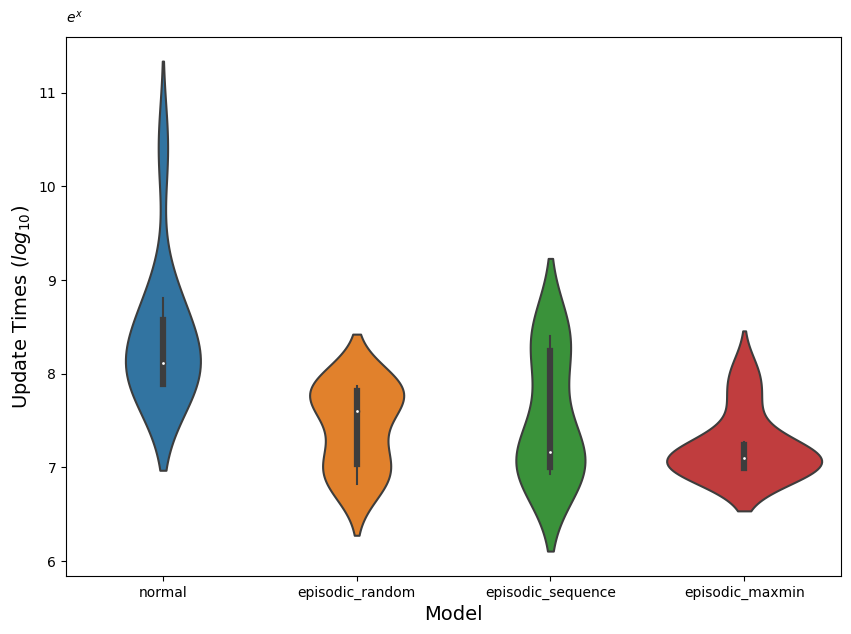

In [43]:
plt.figure(figsize=(10, 7))
df_plot = df_episodic_pd.copy()
df_plot['update_times'] = np.log((df_plot['agent1_updating_times'] + df_plot['agent2_updating_times'] + df_plot['agent3_updating_times'])/3)
ax = sns.violinplot(data=df_plot, x="model", y="update_times")
# formatter = ticker.ScalarFormatter(useMathText=True)
# formatter.set_scientific(True) 
# formatter.set_powerlimits((-1,1)) 
# ax.yaxis.set_major_formatter(formatter) 
plt.text(-.0, 1.05, '$e^x$', ha='left', va='top', transform=ax.transAxes)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Update Times ($log_{10}$)', fontsize=14)

In [90]:
df_plot = df_episodic_pd[df_episodic_pd.matching=='random'].copy()

Text(0, 0.5, 'Update Times ($log_{10}$)')

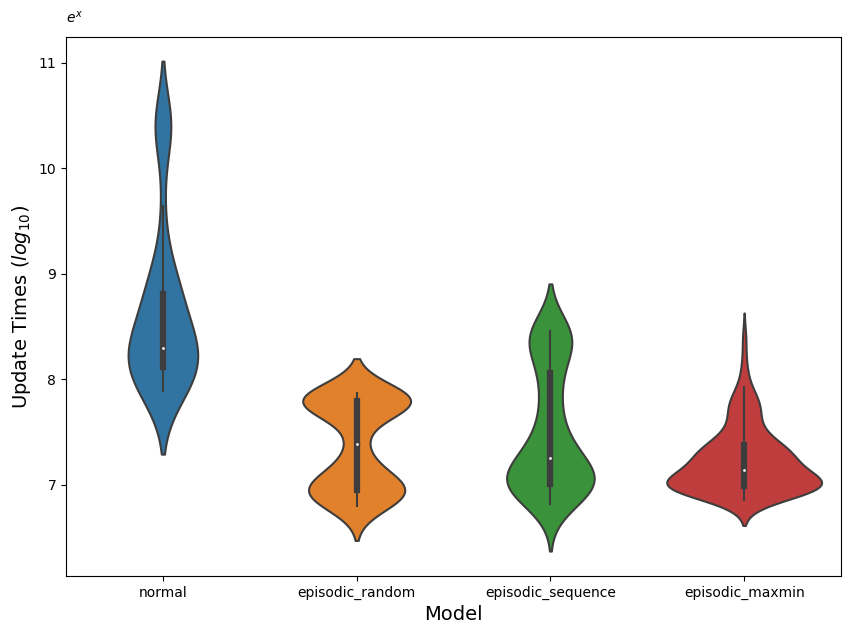

In [91]:
plt.figure(figsize=(10, 7))
df_plot['update_times'] = np.log((df_plot['agent1_updating_times'] + df_plot['agent2_updating_times'] + df_plot['agent3_updating_times'])/3)
ax = sns.violinplot(data=df_plot, x="model", y="update_times")
# formatter = ticker.ScalarFormatter(useMathText=True)
# formatter.set_scientific(True) 
# formatter.set_powerlimits((-1,1)) 
# ax.yaxis.set_major_formatter(formatter) 
plt.text(-.0, 1.05, '$e^x$', ha='left', va='top', transform=ax.transAxes)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Update Times ($log_{10}$)', fontsize=14)

['X' '^' 'o' 's']
['X' 'o' 's']
['X' '^' 'o' 's']
['X' 's']


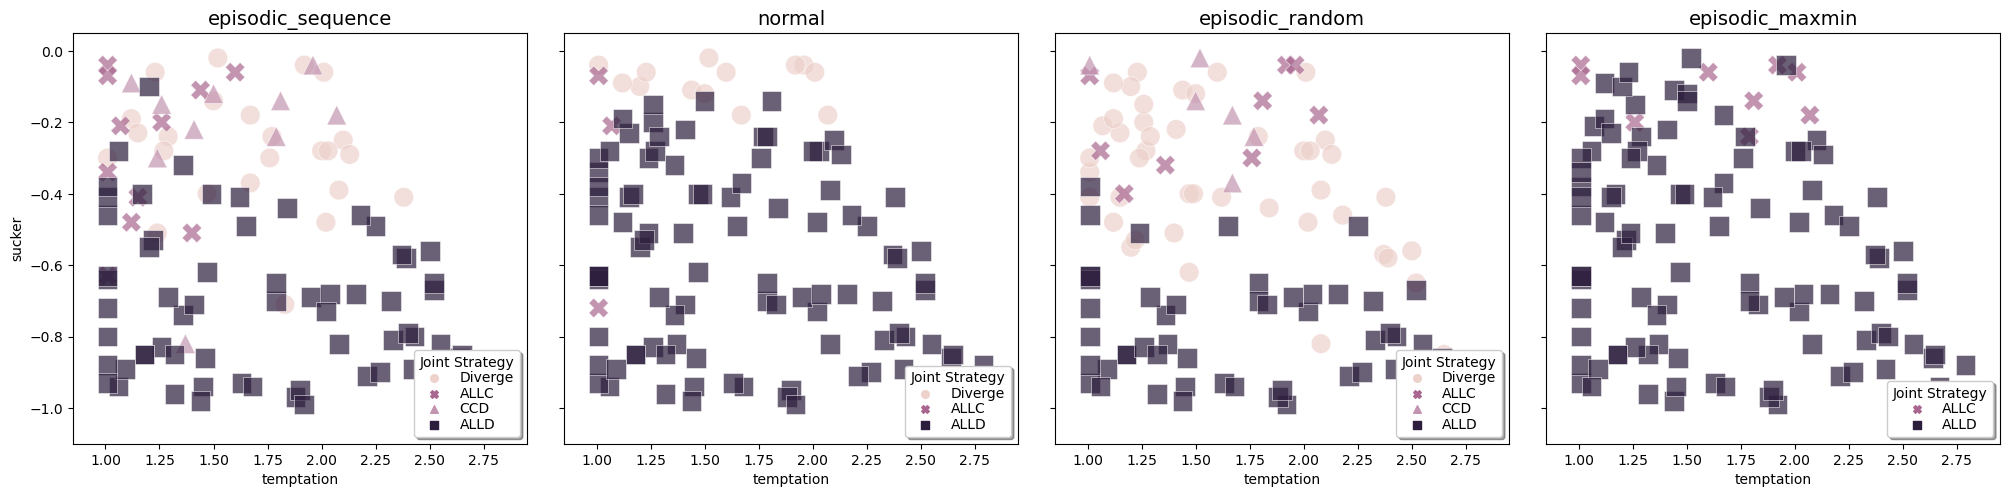

In [92]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

dict_map = {-1:'Diverge', 0:'ALLC', 1:'CCD', 2:'CDD', 3:'ALLD'}
marker_map = {'ALLC':'X', 'CCD':'^', 'CDD':'*' ,'ALLD': 's', 'Diverge':'o'}
palette_map = {'ALLC':'#a9678f', 'CCD':'#c294b0', 'CDD':'#875272' ,'ALLD': '#2d1e3e', 'Diverge':'#edd1cb'}

df_plot = df_episodic_pd.loc[df_episodic_pd.matching=='random'].copy()
# df_plot = df_episodic_pd.copy()
df_plot['final_strategy'] = df_plot['agent1_final_strategy'] + df_plot['agent2_final_strategy'] + df_plot['agent3_final_strategy']
df_plot.loc[df_plot.isna().any(axis=1), 'final_strategy'] = -1
df_plot = df_plot.sort_values(by=['final_strategy'],ascending=True)
df_plot['Final Strategy'] = df_plot.final_strategy.map(dict_map)
df_plot['marker'] = df_plot['Final Strategy'].map(marker_map)
df_plot['palette'] = df_plot['Final Strategy'].map(palette_map)

df_plot.temptation = df_plot.temptation/df_plot.reward
df_plot.sucker = df_plot.sucker/df_plot.reward
df_plot['new_reward'] = 1.0

for key,value in enumerate(list(pd.unique(df_plot.model))):
    df_subplot = df_plot.loc[df_plot.model==value]
    length = len(list(np.unique(df_subplot['Final Strategy'])))
    markers = list(pd.unique(df_subplot.marker))
    palette = list(pd.unique(df_subplot.palette))
    print(np.unique(df_subplot.marker))
    sns.scatterplot(ax=axes[key], data=df_subplot, y='sucker', x='temptation', 
                    hue="Final Strategy", size="Final Strategy", sizes=[200]*length, 
                    style='Final Strategy', markers= markers,
                    linewidth=0.5, alpha=.7, palette=palette)
    lgnd = axes[key].legend(scatterpoints=1, title='Joint Strategy', frameon=True, labelspacing=.1, markerscale=.4, 
                          loc='lower right', shadow=True)
    for i in lgnd.legendHandles:
        i._sizes = [30]

    axes[key].set_title(value, fontsize=14)
    axes[key].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)


# Learn Selection

In [83]:
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=50)

In [84]:
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agent3 = construct_agent('LSTMQN', config_obj)
        
        agents = {}
        agents[0], agents[1], agents[2] = agent1, agent2, agent3 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthorityNormal(config_obj, agents, k, episodic_flag=False, settlement_prob=0.01, update_times=10, select_epsilon_decay=0.999)

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan 
        if 2 not in list(v.keys()):
            convergent_episode_dict[key][2] = np.nan 


    df_episodic_pd.loc[len(df_episodic_pd.index)]= [convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                                    convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                                    convergent_episode_dict['strategy'][2], convergent_episode_dict['reward'][2], 
                                                    config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                                    round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                                    float(torch.sum(agent1.own_memory)/agent1.play_times), agent1.updating_times,
                                                    round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                                    float(torch.sum(agent2.own_memory)/agent2.play_times), agent2.updating_times,
                                                    round(float(torch.sum(agent3.own_memory[agent3.play_times-100:agent3.play_times])/100)),
                                                    float(torch.sum(agent3.own_memory)/agent3.play_times), agent3.updating_times,
                                                    'normal', 'learner']

50it [2:31:17, 181.55s/it]


In [85]:
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agent3 = construct_agent('LSTMQN', config_obj)
        
        agents = {}
        agents[0], agents[1], agents[2] = agent1, agent2, agent3 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.01, update_times=10, episodic_flag=True, select_epsilon_decay=0.999, play_method ='DQN')

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan
        if 2 not in list(v.keys()):
            convergent_episode_dict[key][2] = np.nan


    df_episodic_pd.loc[len(df_episodic_pd.index)]= [convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                                    convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                                    convergent_episode_dict['strategy'][2], convergent_episode_dict['reward'][2], 
                                                    config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                                    round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                                    float(torch.sum(agent1.own_memory)/agent1.play_times), sum(agents[0].updating_times.values()),
                                                    round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                                    float(torch.sum(agent2.own_memory)/agent2.play_times), sum(agents[1].updating_times.values()),
                                                    round(float(torch.sum(agent3.own_memory[agent3.play_times-100:agent3.play_times])/100)),
                                                    float(torch.sum(agent3.own_memory)/agent3.play_times), sum(agents[2].updating_times.values()),
                                                    'episodic_sequence', 'learner']


50it [1:48:52, 130.65s/it]


In [86]:
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agent3 = construct_agent('LSTMQN', config_obj)
        
        agents = {}
        agents[0], agents[1], agents[2] = agent1, agent2, agent3 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.01, update_times=10, episodic_flag=True, select_epsilon_decay=0.999, play_method ='MaxminDQN')

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan
        if 2 not in list(v.keys()):
            convergent_episode_dict[key][2] = np.nan


    df_episodic_pd.loc[len(df_episodic_pd.index)]= [convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                                    convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                                    convergent_episode_dict['strategy'][2], convergent_episode_dict['reward'][2], 
                                                    config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                                    round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                                    float(torch.sum(agent1.own_memory)/agent1.play_times), sum(agents[0].updating_times.values()),
                                                    round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                                    float(torch.sum(agent2.own_memory)/agent2.play_times), sum(agents[1].updating_times.values()),
                                                    round(float(torch.sum(agent3.own_memory[agent3.play_times-100:agent3.play_times])/100)),
                                                    float(torch.sum(agent3.own_memory)/agent3.play_times), sum(agents[2].updating_times.values()),
                                                    'episodic_maxmin', 'learner']


50it [2:08:21, 154.02s/it]


['*' 'X' '^' 'o' 's']
['X' 'o' 's']
['o' 's']


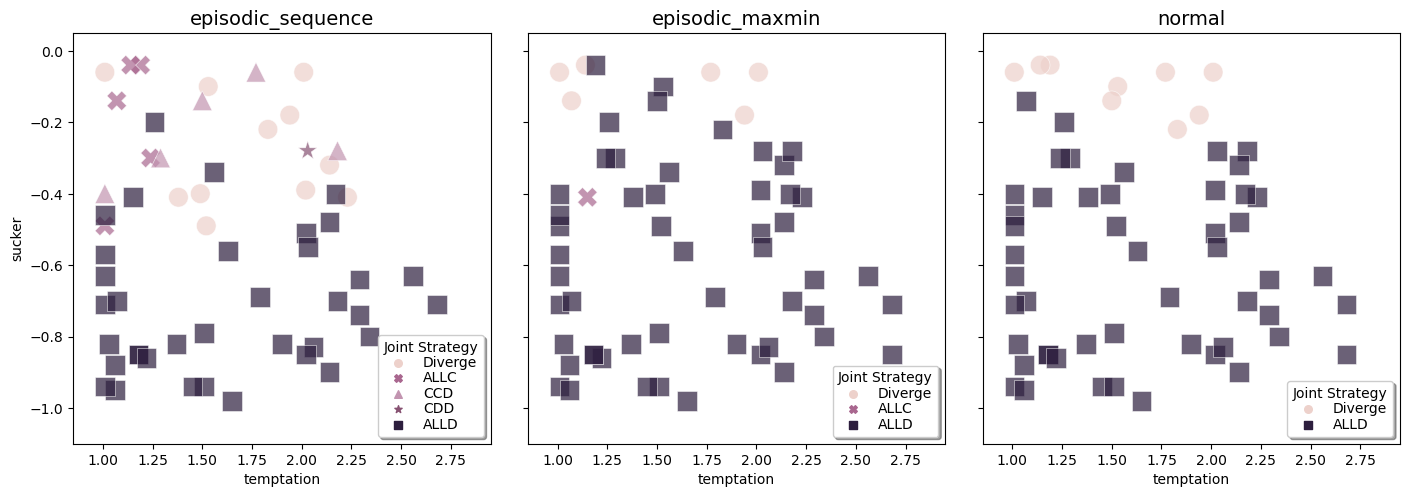

In [96]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

dict_map = {-1:'Diverge', 0:'ALLC', 1:'CCD', 2:'CDD', 3:'ALLD'}
marker_map = {'ALLC':'X', 'CCD':'^', 'CDD':'*' ,'ALLD': 's', 'Diverge':'o'}
palette_map = {'ALLC':'#a9678f', 'CCD':'#c294b0', 'CDD':'#875272' ,'ALLD': '#2d1e3e', 'Diverge':'#edd1cb'}

df_plot = df_episodic_pd.loc[df_episodic_pd.matching!='random'].copy()
# df_plot = df_episodic_pd.copy()
df_plot['final_strategy'] = df_plot['agent1_final_strategy'] + df_plot['agent2_final_strategy'] + df_plot['agent3_final_strategy']
df_plot.loc[df_plot.isna().any(axis=1), 'final_strategy'] = -1
df_plot = df_plot.sort_values(by=['final_strategy'],ascending=True)
df_plot['Final Strategy'] = df_plot.final_strategy.map(dict_map)
df_plot['marker'] = df_plot['Final Strategy'].map(marker_map)
df_plot['palette'] = df_plot['Final Strategy'].map(palette_map)

df_plot.temptation = df_plot.temptation/df_plot.reward
df_plot.sucker = df_plot.sucker/df_plot.reward
df_plot['new_reward'] = 1.0

for key,value in enumerate(list(pd.unique(df_plot.model))):
    df_subplot = df_plot.loc[df_plot.model==value]
    length = len(list(np.unique(df_subplot['Final Strategy'])))
    markers = list(pd.unique(df_subplot.marker))
    palette = list(pd.unique(df_subplot.palette))
    print(np.unique(df_subplot.marker))
    sns.scatterplot(ax=axes[key], data=df_subplot, y='sucker', x='temptation', 
                    hue="Final Strategy", size="Final Strategy", sizes=[200]*length, 
                    style='Final Strategy', markers= markers,
                    linewidth=0.5, alpha=.7, palette=palette)
    lgnd = axes[key].legend(scatterpoints=1, title='Joint Strategy', frameon=True, labelspacing=.1, markerscale=.4, 
                          loc='lower right', shadow=True)
    for i in lgnd.legendHandles:
        i._sizes = [30]

    axes[key].set_title(value, fontsize=14)
    axes[key].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)


In [97]:
df_episodic_pd.to_csv('data/csv/3_agents_experiment.csv', index=False)

In [99]:
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=14)
reward, temptation, sucker, punishment

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1.14, 1.04, 1.25, 1.64, 1.69, 1.4 , 2.11, 1.01, 1.27, 1.35, 1.8 ,
        1.77, 1.08, 1.82]),
 array([-0.63, -0.06, -0.28, -0.41, -0.85, -0.85, -0.94, -0.14, -0.4 ,
        -0.3 , -0.98, -0.04, -0.18, -0.79]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))